##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow 2 quickstart for experts

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/quickstart/advanced"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/quickstart/advanced.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is a [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb) notebook file. Python programs are run directly in the browser—a great way to learn and use TensorFlow. To follow this tutorial, run the notebook in Google Colab by clicking the button at the top of this page.

1. In Colab, connect to a Python runtime: At the top-right of the menu bar, select *CONNECT*.
2. Run all the notebook code cells: Select *Runtime* > *Run all*.

Download and install TensorFlow 2. Import TensorFlow into your program:

Note: Upgrade `pip` to install the TensorFlow 2 package. See the [install guide](https://www.tensorflow.org/install) for details.

Import TensorFlow into your program:

In [3]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2.2.0


Load and prepare the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).

In [29]:
LABEL_COLUMN = 'hard'
LABELS = [0, 1]

raw_dataset = pd.read_csv('ml_data.csv')

dataset = raw_dataset.copy()

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [32]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
productions,102.0,15994.578431,83609.477892,37.0,291.0,613.0,4826.00,597888.0
columns,102.0,4.666667,1.213238,2.0,4.0,5.0,5.00,8.0
filters,102.0,221.647059,893.294776,0.0,0.0,5.0,24.25,5325.0
summarises,102.0,1.460784,1.571224,0.0,0.0,1.0,2.00,8.0
innerjoins,102.0,126.990196,135.443788,1.0,37.0,92.5,148.00,715.0
crossjoins,102.0,15608.588235,82761.981877,0.0,84.0,540.0,4740.00,591804.0
maxcolstype,102.0,3.274510,1.025968,1.0,2.0,3.0,4.00,6.0
outputcols,102.0,2.313725,1.116753,1.0,1.0,2.0,3.00,5.0
inputs,102.0,1.803922,0.844777,1.0,1.0,2.0,2.75,4.0
gencols,102.0,0.862745,0.718072,0.0,0.0,1.0,1.00,4.0


Use `tf.data` to batch and shuffle the dataset:

In [33]:
train_labels = train_dataset.pop('hard')
test_labels = test_dataset.pop('hard')

In [34]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Build the `tf.keras` model using the Keras [model subclassing API](https://www.tensorflow.org/guide/keras#model_subclassing):

In [35]:
def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(7, activation='relu', input_shape=[len(train_dataset.keys())]),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

Choose an optimizer and loss function for training: 

In [36]:
model = build_model()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [44]:
model.summary()
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


Use `tf.GradientTape` to train the model:

In [38]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.        ],
       [-0.0770486 ],
       [-0.1991863 ],
       [ 0.23443098],
       [ 0.8307149 ],
       [ 0.14611235],
       [ 0.05827389],
       [ 0.2753014 ],
       [ 0.11221179],
       [ 0.01690179]], dtype=float32)

Test the model:

In [47]:
EPOCHS = 500

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])

history_dict = history.history
history_dict.keys()


Epoch: 0, accuracy:0.9012,  loss:0.1817,  val_accuracy:0.7619,  val_loss:0.6465,  
....................................................................................................
Epoch: 100, accuracy:0.9136,  loss:0.1683,  val_accuracy:0.7619,  val_loss:0.6907,  
....................................................................................................
Epoch: 200, accuracy:0.9136,  loss:0.1571,  val_accuracy:0.8095,  val_loss:0.7348,  
....................................................................................................
Epoch: 300, accuracy:0.9136,  loss:0.1476,  val_accuracy:0.8095,  val_loss:0.7789,  
....................................................................................................
Epoch: 400, accuracy:0.9136,  loss:0.1393,  val_accuracy:0.7619,  val_loss:0.8261,  
....................................................................................................

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

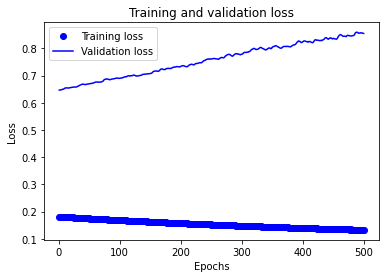

In [48]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

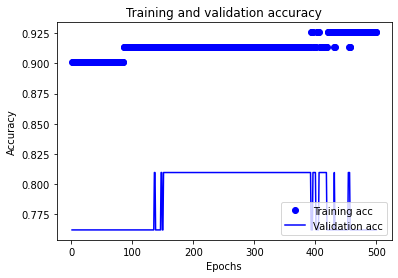

In [49]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).